In [9]:
import numpy as np
from buildingspy.io.outputfile import Reader
import matplotlib.pyplot as plt
import scipy.io as sio

# Introduction

## Aim

Change the data reduction method before DNN training.

## Context

Once pre-processing is completed, we have the tensor `X.mat` of Fourier coefficients for 2 signals: pulmonary artery pressure and systemic artery pressure. Currently, we train the DNN with a reduced amount of coefficients by defining the percentage of coefficients we retain and by applying the following algorithm (line 215, `utils_deeplearning.py`, commit `add1526`):

In [ ]:
if (perccoef < 0.99999):
    if nfrequencies % 2 == 0:
        aks = (nfrequencies + 2) / 2
        bks = aks - 2
    else:
        aks = (nfrequencies + 1) / 2
        bks = aks - 1
    aks = int(aks)
    selectedaks = int(np.floor(aks * perccoef))
    indicestoselect = list(range(0, selectedaks)) + list(range(aks, aks + selectedaks - 1))
    X = np.take(X, indicestoselect, axis=2)
    nfrequencies = X.shape[2]

Implementation of the Artificial Pulse feature of HMIII required to run simulations over a longer simulation time in order to have stabilized values. We want to consider the same time window (the last 10 seconds of the simulation) and account for the fact that the number of coefficients is not necessarily the same between two different simulations. That occurs when we change the time discretization parameters of the simulation, i.e. the simulation time ($T_{sim}$) and the number of intervals ($N$). If the ratio $T_{sim} / N$ changes, then the number of data points is not constant, and the number of Fourier coefficients is also not the same. 

# Implementation of alternative data reduction method

## Mathematical background

We first compute the complex Fourier coefficients $c_k$ according to the Fast Fourier Transform algorithm. We can reconstruct the original signal with the formula

$$
\tilde f(x) = \sum_{k=-(M+\mu)}^{M+\mu} c_k e^{ikx}
$$

With $\mu$ being 0 if $n$ is even, and 1 if $n$ is odd; $M = (n - \mu)/2$.

## Computational background

We rather store and compute the coefficients $a_k$, $b_k$:

$$
a_k = c_k + c_{-k}
$$
$$
b_k = i(c_k - c_{-k})
$$

All values are stored in a 3D-tensor $X[i, j, k]$, where

* $i$ denotes the sample number (one of the ten thousand simulations)
* $j$ denotes the index of the input variable (SAP or PAP)
* $k$ denotes the index for the coefficients, i.e. $X[i, j, :] = \{ a_0, a_1, \dots, a_l, b_1, b_2, \dots, b_l \}$

The coefficient $b_0$ was discarded during pre-processing since it is always 0.

### Reconstruction algorithm


In [1]:
def reconstruct(aks, bks, t, T):
    x = t * 0 + aks[0] / 2
    for k in range(1, len(aks)):
        x += aks[k] * np.cos(2*np.pi*t * k / T) + \
             bks[k] * np.sin(2*np.pi*t * k / T)
    return x

## Load simulation data



In [3]:
folder = '/media/maousi/Data/tmp/simulations_2020_03_21/outputs/'
file = 'Ursino1998Model_VAD2_output_1003.mat'

In [4]:
reader = Reader(folder+file, 'dymola')

In [5]:
t, signal = reader.values('SystemicArteries.PC')

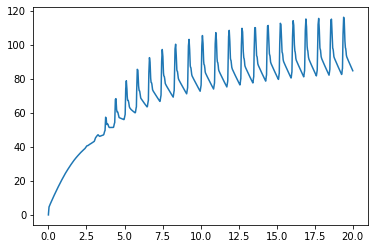

In [8]:
plt.plot(t, signal);

## Load DNN input data

In [12]:
folder_X = folder + '../'

In [15]:
X = sio.loadmat(folder_X+'X.mat')['X']
X.shape

(10000, 2, 250)

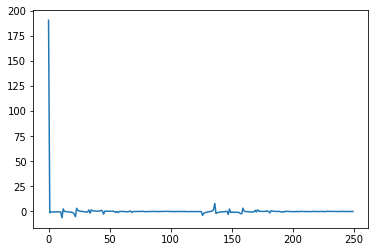

In [17]:
plt.plot(X[0, 0, :])

In [52]:
def get_b1_index(array_length):
    if array_length % 2 == 0:
        return int((array_length + 2) / 2)
    return int((array_length + 1)/2)

In [57]:
nfreq = X.shape[2]
b1_i = get_b1_index(nfreq)

In [66]:
X[:, 0, 0:2].mean(axis=0)

array([181.10259117,  -0.86442602])

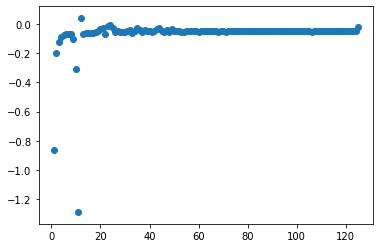

In [71]:
plt.scatter(range(1, b1_i), X[:, 0, 1:b1_i].mean(axis=0))

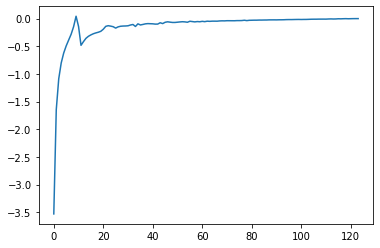

In [69]:
plt.plot(X[:, 0, b1_i:].mean(axis=0))

In [95]:
aks = x[:126]
bks = x[126:]
bks = np.append([0], bks)
bks = np.append(bks, [0])# bks is lacking 1 element ????

In [101]:
aks = x[:30]
bks = x[126:155]
bks = np.append([0], bks)

In [102]:
t = np.linspace(0, 10, 1000)
sig = reconstruct(aks, bks, t, 10)

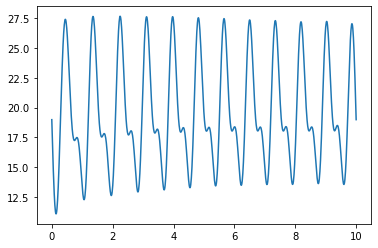

In [103]:
plt.plot(t, sig)

In [ ]:
X[:, 0, :]

# Algo

In [85]:
def get_b1_index(array_length):
    if array_length % 2 == 0:
        return int((array_length + 2) / 2)
    return int((array_length + 1)/2)

def reduce(perc, array_length, selectedaks = None):
    """Return a list of indices (i.e. use them by applying np.take).
    You can choose the extent of data reduction with:
    - perc: percentage of coefficients to keep
    - selectedaks: impose a given number of ak coefficients
    Note that in both cases, there is one additional ak returned (b0=0, a0 =/= 0)
    """
    # b1_id = index of b1 coeff = number of aks
    b1_id = get_b1_index(array_length)
    
    if selectedaks is None:
        selectedaks = int(np.floor(b1_id * perc))
    indicestoselect = list(range(0, selectedaks)) + list(range(b1_id, b1_id + selectedaks - 1))
    return indicestoselect

In [86]:
nfreq = X.shape[2]
id_select = reduce(0.05, nfreq)

In [87]:
id_select

[0, 1, 2, 3, 4, 5, 126, 127, 128, 129, 130]

In [91]:
# Now we impose to take a certain number of aks
reduce(None, nfreq, 6)

[0, 1, 2, 3, 4, 5, 126, 127, 128, 129, 130]

In [104]:
reduce(None, nfreq, 2)

[0, 1, 126]

In [106]:
folder2 = '/media/maousi/Data/tmp/simulation_LVAD_RPM4000_Pulse_T30_N2000_2020_04_26/'
X2 = sio.loadmat(folder2+'X.mat')['X']
X2.shape

(10000, 2, 667)

In [107]:
get_b1_index(X2.shape[2])

334

In [109]:
ids = reduce(0.05, X2.shape[2])
ids

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 334,
 335,
 336,
 337,
 338,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 348]

In [110]:
len(ids)

31